## Example dataset

In [ ]:
import sys
sys.path.append('..')
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
from itertools import product
import math
import skhubness
import igraph
import networkx as nx
import scipy
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
import utils
import benchmark_common_functions

def nn_density(X,k=10):
    N=len(X)
    d=X.shape[1]
    sph_volume = lambda r,d: r**d * ( math.pi**(d/2) ) / math.gamma(d/2 + 1)
    dist, idx = NearestNeighbors(n_neighbors=k).fit(X).kneighbors()
    density = np.zeros(len(X))
    for i in range(len(X)):
        r = dist[i,-1]
        density[i] = (k/N)*(1/sph_volume(r,d))
    return density

def gauss_kernel(nn_dists, dimension, N, sigma): 
    return np.sum( np.exp(-nn_dists**2 / (2*sigma**2))  
                  / (np.sqrt(sigma*2*np.pi))**dimension 
                 ) / N

def nn_gauss_kde(nn_dists,dimension,sigma=0.1):
    N=len(nn_dists)
    density = np.zeros(len(X))
    for i in range(len(X)):
        density[i] = gauss_kernel(nn_dists[i], dimension, N, sigma)
    return density

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [56]:
rootdir = '/mnt/c/Users/jobac/Desktop/all/singlecell-id-paper/data/Cytotrace_raw_datasets/anndata/'
resdir = '../results/Cytotrace_raw_datasets/hubness_results/'

fnames = np.array(os.listdir(rootdir))
sort_fnames = np.argsort(list(map(lambda fname : int(fname.split('_')[2].split('.')[0]),fnames)))
fnames_cyto = fnames[sort_fnames]

get_res_path_cyto = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'

In [57]:
#fixed params
do_log = True #already done with do_norm
do_pca = True
n_neighbors = 10
seed = 0

#vary params
metric=('cosine','euclidean')
n_comps=(25,50,100,500)
weighted=(True,)
do_norm = ('duo','seurat')#,'zheng17')
norm_scale = (True,False)
params_list = list(product(metric,n_comps,weighted,do_norm,norm_scale))

#raw results
results_dicts = {}
for metric,n_comps,weighted,do_norm,norm_scale in params_list:
    results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)] = {}
            
    resdir = '../results/Cytotrace_raw_datasets/hubness_results/'
    for fname in fnames_cyto[10:11]:
        with open(get_res_path_cyto(fname[:-5]),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0][4:]] = pickle.load(f)
            
#parsed results
parsed_results_dicts = {}

for k,results_dict in results_dicts.items():
    parsed_results_dicts[k] = {}
    
    (parsed_results_dicts[k]['hubness_dfs'], 
     parsed_results_dicts[k]['clus'], 
     parsed_results_dicts[k]['clus_scores'],
     parsed_results_dicts[k]['clus_info']) = benchmark_common_functions.parse_results_dict(results_dict)

In [58]:
##kde
sigma = 10
#n_neighbors = int(np.sqrt(len(adata.X)))

##clus
n_comps = 50
knn_methods = ['base','ls','dsl','scanpy_umap']
clus_method = 'leiden'
metric = 'ARI'
distance = 'euclidean'
preproc = 'seurat'
norm_scale = True
weighted = True
preproc_key = (distance,n_comps,weighted,preproc,norm_scale)
seed = 0

##plot
s=20
alpha=.8
linewidth=.2

##dataset
rootdir = '/mnt/c/Users/jobac/Desktop/all/singlecell-id-paper/data/Cytotrace_raw_datasets/anndata/'
fname = 'GSE60783_10'
adata = sc.read(rootdir+f'raw_{fname}.h5ad')
benchmark_common_functions.recipe_seurat(adata,do_log=1,norm_scale=norm_scale)
sc.tl.pca(adata, n_comps=n_comps)
var_expl = adata.uns['pca']['variance_ratio']
X = adata.obsm['X_pca']
X_labels = adata.uns['Phenotype']

In [59]:
#get density

adjmats = {}
nn_dists = {}
kskews = {}
kdens = {}
for i,knn_met in enumerate(knn_methods):
    if knn_met in ['scanpy_umap','scanpy_gauss']:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors+1, metric=distance,use_rep='X_pca', method='umap')
        adjmat = adata.obsp['connectivities']
        adjmats[knn_met] = adjmat
        
        nn_dists[knn_met] = [[] for i in range(len(X))]
        for i,j in zip(adjmat.tocoo().row, adjmat.tocoo().col):
            nn_dists[knn_met][i].append(adjmat[i,j])
        nn_dists[knn_met] = [np.array(l) for l in nn_dists[knn_met]]
        
        k_occurrence = np.bincount(adjmat.tocoo().col, minlength=len(X))
        kskews[knn_met] = scipy.stats.skew(k_occurrence)
        
    else:
        if knn_met == 'base':
            hubness = None
            hubness_params = None
        elif knn_met == 'ls_nicdm':
            hubness = 'ls'
            hubness_params = {'method':'nicdm'}
        elif knn_met == 'ls':
            hubness = 'ls'
            hubness_params = None
        elif knn_met == 'mp_normal':
            hubness = 'mp'
            hubness_params = {'method':'normal'}
        elif knn_met == 'dsl':
            hubness = 'dsl'
            hubness_params = None
        else:
            raise ValueError('wrong method name')
            
        hub = skhubness.Hubness(k = n_neighbors, 
                                metric = distance, 
                                hubness=hubness, hubness_params=hubness_params,
                                random_state=seed, store_k_occurrence=True,return_value='all').fit(adata.obsm['X_pca'])
        kskews[knn_met] = hub.score()['k_skewness']
        nn_dists[knn_met], idx = hub.nn_index_.kneighbors()
        adjmats[knn_met] = hub.nn_index_.kneighbors_graph(mode='distance')
        
    kdens[knn_met] = nn_gauss_kde(nn_dists[knn_met],X.shape[1],sigma=sigma)


In [60]:
#get colored cluster labels

all_clus_labels = {}
col_clus_labels = {}
for i,knn_met in enumerate(knn_methods):
    clus_labels = parsed_results_dicts[preproc_key]['clus'][knn_met][fname][clus_method].copy()
    #reorder coloring to match ground truth coloring
    if knn_met == 'base':
        if n_neighbors==10:
            ix1 = clus_labels==0; ix2 = clus_labels==1
            clus_labels[ix1], clus_labels[ix2] = 1,0
        elif n_neighbors==15:
            ix1 = clus_labels==1; ix2 = clus_labels==2
            clus_labels[ix1], clus_labels[ix2] = 2,1
    if knn_met == 'scanpy_umap':
        ix1 = clus_labels==1; ix2 = clus_labels==2
        clus_labels[ix1], clus_labels[ix2] = 2,1
    if knn_met in ['ls','dsl']:
        ix1 = clus_labels==0; ix2 = clus_labels==1; ix3 = clus_labels==2
        clus_labels[ix1], clus_labels[ix2], clus_labels[ix3] = 2,0,1
        
    all_clus_labels[knn_met] = clus_labels
    col_clus_labels[knn_met],_ = utils.labels_to_color(clus_labels)

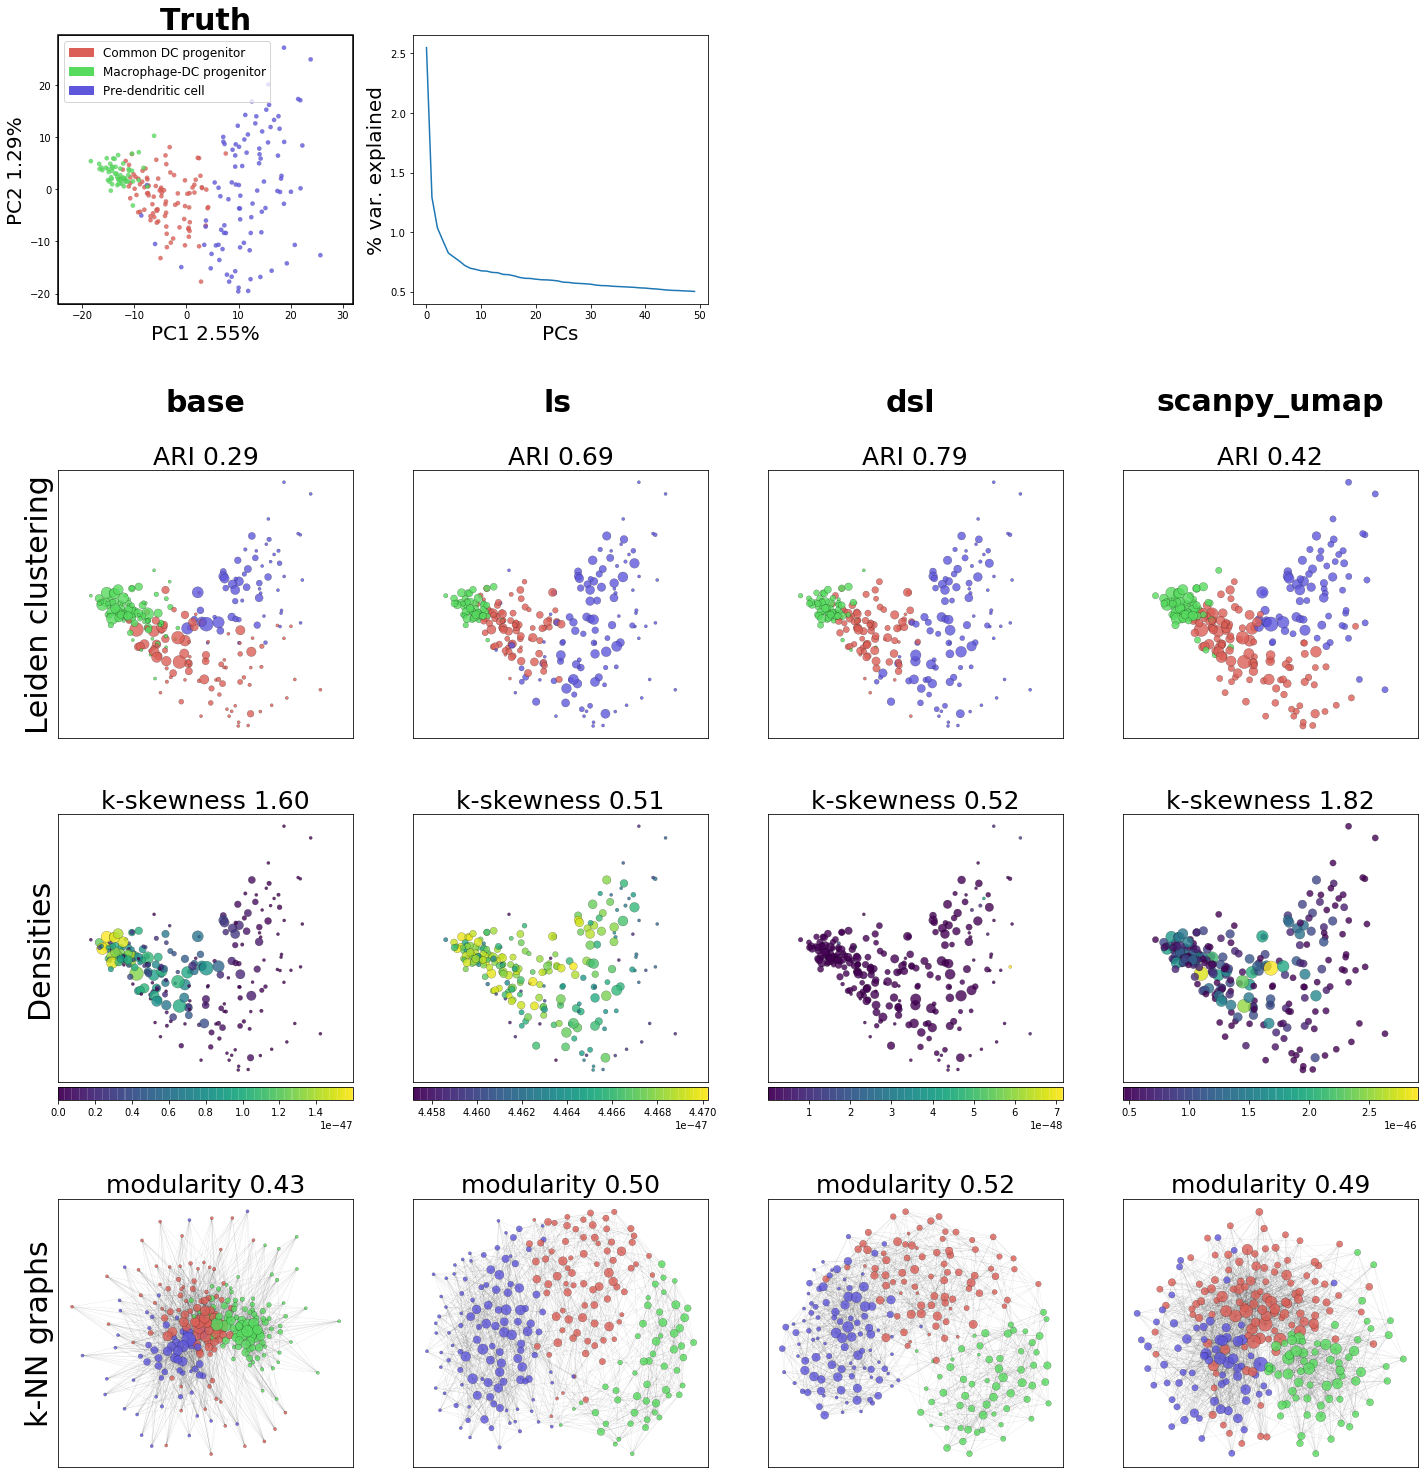

In [66]:
f,axs=plt.subplots(5,4,figsize=(20,20),gridspec_kw={"height_ratios":[1, 1, 1, 0.05, 1]})
#f.subplots_adjust(hspace=.5)
axs=axs.flat

col,legend = utils.labels_to_color(X_labels)
ax=next(axs)
ax.scatter(*X[:,:2].T,c=col,s=s,alpha=alpha,edgecolor='k',linewidth=linewidth/4)
ax.legend(handles=legend)
ax.set_xlabel(f'PC1 {var_expl[0]:.2%}',fontsize=20)
ax.set_ylabel(f'PC2 {var_expl[1]:.2%}',fontsize=20)
ax.set_title('Truth',fontsize=30,fontweight='semibold')
ax.axis('equal')
ax.patch.set_linewidth(1.5)  
ax.patch.set_edgecolor('black')  

ax=next(axs)
ax.plot(var_expl*100)
#_ = ax.axhline(var_expl[0]*10,c='r',linestyle='--')
#_.set_label('conditional number cutoff')
#ax.legend()
ax.set_ylabel('% var. explained',fontsize=20)
ax.set_xlabel('PCs',fontsize=20)

for i in range(2):
    ax=next(axs)
    ax.axis('off')
    
text_positions = [.145,.39,.635,.885]
for i,knn_met in enumerate(knn_methods):
    col = col_clus_labels[knn_met]    
    ax=next(axs)
    plt.gcf().text(text_positions[i], .78, 
            f'{knn_met}',
            verticalalignment='center', 
            horizontalalignment='center',
            fontsize=30,fontweight='semibold')
    DG = nx.from_numpy_matrix(adjmats[knn_met].todense(),create_using=nx.DiGraph)
    ax.scatter(*X[:,:2].T,c=col,s=[10+DG.in_degree()[k]*3 for k in np.arange(len(X))]
               ,alpha=alpha,edgecolor='k',linewidth=linewidth)
    ax.set_title(f'ARI '+str(round(parsed_results_dicts[preproc_key]['clus_scores'][knn_met][fname][metric][clus_method],2)),fontsize=25)
    ax.axis('equal')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if i==0:
        #ax.set_ylabel(preproc_key[0]+' '+str(preproc_key[1]),fontsize=30)
        ax.set_ylabel('Leiden clustering', fontsize=30)

        
mapp = []
for i,knn_met in enumerate(knn_methods):
    ax=next(axs)
    DG = nx.from_numpy_matrix(adjmats[knn_met].todense(),create_using=nx.DiGraph)
    mapp.append(ax.scatter(*X[:,:2].T,c=kdens[knn_met],s=[10+DG.in_degree()[k]*3 for k in np.arange(len(X))]
                           ,alpha=alpha,edgecolor='k',linewidth=linewidth))#,norm=mpl.colors.LogNorm()))
    ax.set_title(f'k-skewness {kskews[knn_met]:.2f}',fontsize=25)
    ax.axis('equal')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if i==0:
        ax.set_ylabel('Densities',fontsize=30)     
        
for i in range(4):
    ax=next(axs)
for i,knn_met in enumerate(knn_methods):
    ax=next(axs)
    col = col_clus_labels[knn_met]    
    G = nx.from_numpy_matrix(adjmats[knn_met].todense(),create_using=nx.Graph)
    DG = nx.from_numpy_matrix(adjmats[knn_met].todense(),create_using=nx.DiGraph)
    modularity = nx.algorithms.community.quality.modularity(DG,[np.where(all_clus_labels[knn_met]==i)[0] for i in range(3)])
    pos = nx.kamada_kawai_layout(G,scale=2)
    nx.draw_networkx(G,pos=pos, 
                     arrowsize=5,
                     nodelist = list(np.arange(len(X))),
                     node_size = [10+DG.in_degree()[k]*3 for k in np.arange(len(X))],
                     width = .05,
                     alpha = alpha,
                     with_labels=False,
                     node_color=col,
                     edgecolors='k',
                     linewidths=linewidth,
                     ax = ax)
    ax.set_title(f'modularity {modularity:.2f}',fontsize=25)
    #ax.axis('equal')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if i==0:
        ax.set_ylabel('k-NN graphs',fontsize=30)
        
        
plt.tight_layout()

#reposition
for i in range(2):
    l, b, w, h = axs[i].get_position().bounds
    axs[i].set_position([l,b*1.08, w, h])
for i,m in enumerate(mapp):
    cbar = plt.colorbar(m, cax=axs[i+12], orientation="horizontal")
    #for label in cbar.ax.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    l, b, w, h = axs[i+12].get_position().bounds
    axs[i+12].set_position([l,b*1.2, w, h])   
for i in range(4):
    l, b, w, h = axs[i+16].get_position().bounds
    axs[i+16].set_position([l,b*5.5, w, h])  
    
#save    
plt.savefig(f'../figures/example_{fname}_{metric}_{clus_method}_{do_norm}_{norm_scale}_{weighted}_{n_comps}_{n_neighbors}',
            dpi=300,bbox_inches='tight')
#plt.close()